Скачивание и обработка датасета

In [7]:
import numpy as np
import pandas as pd

data = pd.read_csv ('card_transdata.csv')
data = data [data.distance_from_home <= 1000]
data = data [data.distance_from_last_transaction <= 1000]
data = data [data.ratio_to_median_purchase_price <= 50]
labels = data ['fraud'].to_numpy ()
data = data.drop (['fraud'], axis = 1).to_numpy ()
pass

Разделение выборки на обучающую и тестовую, определение вспомогательной функции для вывода метрик

In [8]:
from sklearn.model_selection import train_test_split
trainData, testData, trainLabels, testLabels = train_test_split (data, labels, train_size = 0.8, random_state = 1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay
def showMetrics (model, data, labels):
    prediction = model.predict (data)
    print ('Accuracy: ', accuracy_score (labels, prediction))
    print ('Precision: ', precision_score (labels, prediction))
    print ('Recall: ', recall_score (labels, prediction))
    ConfusionMatrixDisplay.from_predictions (labels, prediction)
    RocCurveDisplay.from_predictions (labels, prediction)

### Логистическая регрессия

Определение модели

In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin

class LogisticRegression (BaseEstimator, ClassifierMixin):
    def __init__ (self, lr = 0.01, batch_size = 100, epochs = 5):
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

    def sigmoid (self, x):
        return 1 / (1 + np.exp (- x))
    
    def fit (self, data, labels):
        self.w = np.random.normal (0, 1, (data.shape [1] + 1,))
        data = np.concatenate ((data, np.ones ((data.shape [0], 1))), axis = 1)
        for j in range (self.epochs):
            for i in range (self.batch_size, len (data), self.batch_size):
                batchData = data [i - self.batch_size:i]
                batchLabels = labels [i - self.batch_size:i]
                prediction = self.sigmoid (np.dot (self.w, batchData.T))
                self.w -= self.lr * (self.w + np.dot (prediction - batchLabels, batchData))
        return self
    
    def predict (self, data):
        return (self.sigmoid (np.concatenate ((data, np.ones ((data.shape [0], 1))), axis = 1).dot (self.w)) > 0.5).astype('float32')

Подбор гиперпараметров при помощи RandomizedSearch

In [2]:
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [22]:
rcv = RandomizedSearchCV (Pipeline ([('normalizer', Normalizer ()), ('log', LogisticRegression ())]),
                    {'log__lr': [0.01, 0.001, 0.0001], 'log__epochs': [1, 5, 10], 'log__batch_size': [100, 1000, 10000]})
rcv.fit (trainData, trainLabels)
print (rcv.best_params_, '\n', rcv.best_score_)

{'log__lr': 0.0001, 'log__epochs': 10, 'log__batch_size': 1000} 
 0.9149527029841871


Подбор гиперпараметров при помощи GridSearch

In [23]:
gcv = GridSearchCV (Pipeline ([('normalizer', Normalizer ()), ('log', LogisticRegression ())]),
                    {'log__lr': [0.01, 0.001, 0.0001], 'log__epochs': [1, 5, 10], 'log__batch_size': [100, 1000, 10000]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)

{'log__batch_size': 1000, 'log__epochs': 10, 'log__lr': 0.0001} 
 0.9148976623291583


Вывод метрик для модели с лучшими найденными параметрами

Accuracy:  0.9150679996397371
Precision:  0.6171581769436997
Recall:  0.06610763310550802


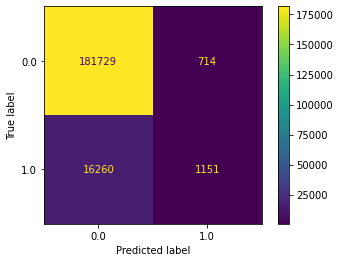

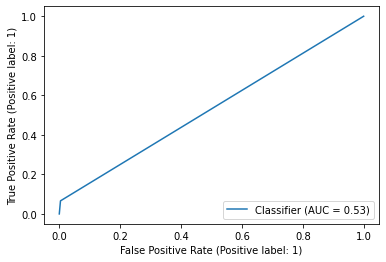

In [24]:
logReg = gcv.best_estimator_
showMetrics (logReg, testData, testLabels)

Загрузка подобранных параметров в файл .pkl

In [25]:
import pickle
with open ('logReg.pkl', 'wb') as f:
    pickle.dump (logReg, f, pickle.HIGHEST_PROTOCOL)

Коробочное решение

{'log__alpha': 0.001, 'log__eta0': 0.001, 'log__max_iter': 1000} 
 0.9145086271200629
Accuracy:  0.9149929448497404
Precision:  0.6002851711026616
Recall:  0.07254034805582678


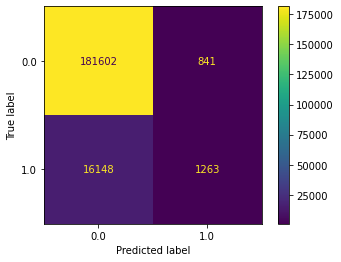

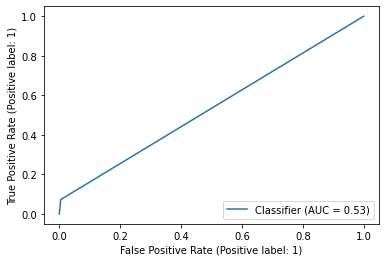

In [26]:
from sklearn.linear_model import SGDClassifier
gcv = GridSearchCV (Pipeline ([('normalizer', Normalizer()), ('log', SGDClassifier (loss = 'log', learning_rate = 'constant'))]),
                    {'log__eta0': [0.1, 0.01, 0.001], 'log__max_iter': [100, 1000, 5000], 
                     'log__alpha': [0.01, 0.001, 0.0001]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)
logRegSK = gcv.best_estimator_
showMetrics (logRegSK, testData, testLabels)

### Метод опорных векторов

Определение модели

In [27]:
class SVM (BaseEstimator, ClassifierMixin):
    def __init__ (self, lr = 0.0001, batch_size = 1000, epochs = 10, alpha = 0.0001):
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.alpha = alpha

    def fit (self, data, labels):
        self.w = np.random.normal (0, 1, (data.shape [1] + 1,))
        data = np.concatenate ((data, np.ones ((data.shape [0], 1))), axis = 1)
        labels = labels * 2 - 1
        for j in range (self.epochs):
            for i in range (self.batch_size, len(data), self.batch_size):
                batchData = data [i - self.batch_size:i]
                batchLabels = labels [i - self.batch_size:i]
                grad = 2 * self.alpha * self.w
                for i, x in enumerate (batchData):
                    if (1 - x.dot (self.w) * batchLabels [i] > 0):
                        grad -= x * batchLabels [i]
                self.w -= self.lr * grad
        return self

    def predict (self, data):
        return (np.sign (np.concatenate ((data, np.ones ((data.shape [0], 1))), axis = 1).dot (self.w)) + 1) / 2

Подбор гиперпараметров при помощи RandomizedSearch

In [4]:
from sklearn.preprocessing import StandardScaler

In [28]:
rcv = RandomizedSearchCV (Pipeline ([('scaler', StandardScaler ()), ('svm', SVM ())]),
                    {'svm__lr': [0.01, 0.001, 0.0001], 'svm__epochs': [1, 5, 10], 
                     'svm__batch_size': [100, 1000, 10000], 'svm__alpha': [0.01, 0.001, 0.0001]})
rcv.fit (trainData, trainLabels)
print (rcv.best_params_, '\n', rcv.best_score_)

{'svm__lr': 0.001, 'svm__epochs': 5, 'svm__batch_size': 1000, 'svm__alpha': 0.0001} 
 0.9621122452147821


Подбор гиперпараметров при помощи GridSearch

In [30]:
gcv = GridSearchCV (Pipeline ([('scaler', StandardScaler ()), ('svm', SVM ())]),
                    {'svm__lr': [0.01, 0.001], 'svm__epochs': [1, 5, 10], 
                     'svm__batch_size': [100, 1000, 10000], 'svm__alpha': [0.001, 0.0001]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)

{'svm__alpha': 0.001, 'svm__batch_size': 1000, 'svm__epochs': 10, 'svm__lr': 0.001} 
 0.9621497728210275


Вывод метрик для модели с лучшими найденными параметрами

Accuracy:  0.9628478789516347
Precision:  0.8874146492861577
Recall:  0.6568835793463902


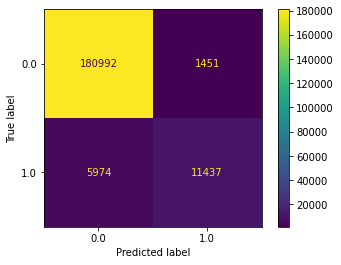

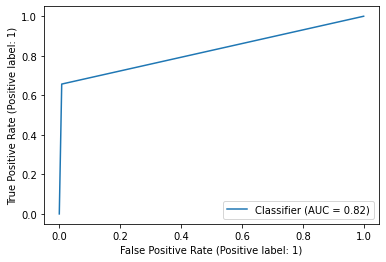

In [31]:
svm = gcv.best_estimator_
showMetrics (svm, testData, testLabels)

Загрузка подобранных параметров в файл .pkl

In [32]:
with open ('svm.pkl', 'wb') as f:
    pickle.dump (svm, f, pickle.HIGHEST_PROTOCOL)

Коробочное решение

{'svm__alpha': 0.0001, 'svm__eta0': 0.1, 'svm__max_iter': 5000} 
 0.9134365916148098
Accuracy:  0.9128814034244999
Precision:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall:  0.0


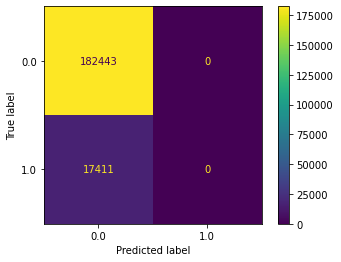

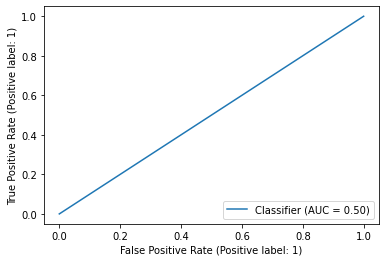

In [33]:
gcv = GridSearchCV (Pipeline ([('normalizer', Normalizer ()), ('svm', SGDClassifier (loss = 'hinge', learning_rate = 'constant'))]),
                    {'svm__eta0': [0.1, 0.01, 0.001], 'svm__max_iter': [100, 1000, 5000], 
                     'svm__alpha': [0.01, 0.001, 0.0001]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)
svmSK = gcv.best_estimator_
showMetrics (svmSK, testData, testLabels)

### Метод k-ближайших соседей

Определение модели

In [34]:
class KNN (BaseEstimator, ClassifierMixin):
    def __init__ (self, k = 5):
        self.k = k
    
    def fit (self, data, labels):
        self.data = data
        self.labels = labels
        return self
    
    def predict (self, data):
        res = np.ndarray ((data.shape [0],))
        for i, x in enumerate (data):
            neighbors = np.argpartition (((self.data - data[i]) ** 2).sum (axis = 1), self.k - 1) [:self.k]
            values, counts = np.unique (self.labels [neighbors], return_counts = True)
            res[i] = values [counts.argmax ()]
        return res

Подбор гиперпараметров при помощи GridSearch

In [53]:
# Очень долго считает, уменьшу размер датасета
data = pd.read_csv ('/card_transdata.csv')
data = data [data.distance_from_home <= 1000]
data = data [data.distance_from_last_transaction <= 1000]
data = data [data.ratio_to_median_purchase_price <= 50]
data.drop_duplicates ()
np.random.seed (10)
remove_n = 980000
drop_indices = np.random.choice (data.index, remove_n, replace = False)
reducedData = data.drop (drop_indices)
reducedData.info ()
rlabels = reducedData ['fraud'].to_numpy ()
rdata = reducedData.drop (['fraud'], axis = 1).to_numpy ()
rtrainData, rtestData, rtrainLabels, rtestLabels = train_test_split (rdata, rlabels, train_size = 0.8, random_state = 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19268 entries, 21 to 999966
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              19268 non-null  float64
 1   distance_from_last_transaction  19268 non-null  float64
 2   ratio_to_median_purchase_price  19268 non-null  float64
 3   repeat_retailer                 19268 non-null  float64
 4   used_chip                       19268 non-null  float64
 5   used_pin_number                 19268 non-null  float64
 6   online_order                    19268 non-null  float64
 7   fraud                           19268 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [54]:
gcv = GridSearchCV (Pipeline ([('scaler', StandardScaler ()), ('knn', KNN ())]),
                    {'knn__k': [5]})
gcv.fit (rtrainData, rtrainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)

{'knn__k': 5} 
 0.9938366664189944


Вывод метрик для модели с лучшими найденными параметрами

Accuracy:  0.9929942916450442
Precision:  0.9762611275964391
Recall:  0.9454022988505747


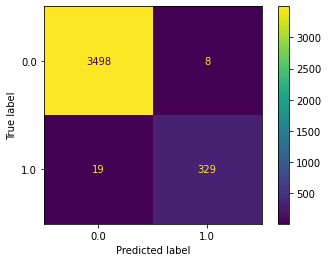

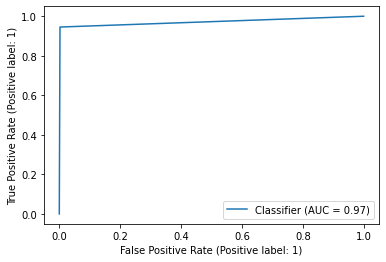

In [55]:
knn = gcv.best_estimator_
showMetrics (knn, rtestData, rtestLabels)

Загрузка подобранных параметров в файл .pkl

In [56]:
with open ('knn.pkl', 'wb') as f:
    pickle.dump (knn, f, pickle.HIGHEST_PROTOCOL)

Коробочное решение

{'knn__n_neighbors': 5} 
 0.9986552649189987
Accuracy:  0.9989142073713811
Precision:  0.9955043227665706
Recall:  0.9920165412670151


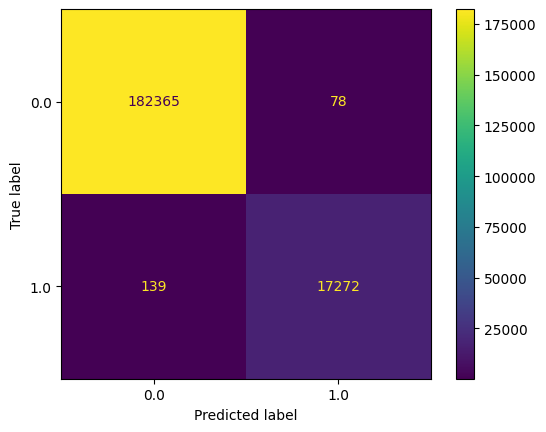

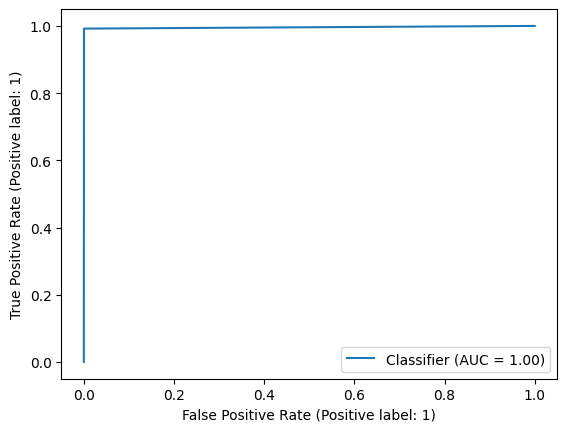

In [9]:
from sklearn.neighbors import KNeighborsClassifier
gcv = GridSearchCV (Pipeline ([('scaler', StandardScaler ()), ('knn', KNeighborsClassifier ())]),
                    {'knn__n_neighbors': [5]})
gcv.fit (trainData, trainLabels)
print (gcv.best_params_, '\n', gcv.best_score_)
knnSK = gcv.best_estimator_
showMetrics (knnSK, testData, testLabels)

### Наивный байесовский классификатор

Определение модели

In [51]:
from scipy.stats import gaussian_kde
class NaiveBayes (BaseEstimator, ClassifierMixin):
    def __init__ (self):
        pass
    
    def fit (self, data, labels):
        self.data = data
        self.labels = labels
        self.kde = []
        for c, count in zip (*np.unique (labels, return_counts = True)):
            self.kde.append ([])
            for i in range (data.shape [1]):
                self.kde [-1].append (gaussian_kde (data [labels == c, i]))
        self.classes = np.unique (labels, return_counts = True) [1] / len (labels)
        return self
    
    def predict (self, data):
        res = np.ndarray ((data.shape [0],))
        for i, obj in enumerate (data):
            prob = np.array (self.classes)
            for j in range (len (self.classes)):
                for k, kde in enumerate (self.kde [j]):
                    prob [j] *= kde (obj [k]) [0]
            res [i] = prob.argmax ()
        return res

Вывод метрик

Accuracy:  0.9359107420861442
Precision:  0.8531468531468531
Recall:  0.3505747126436782


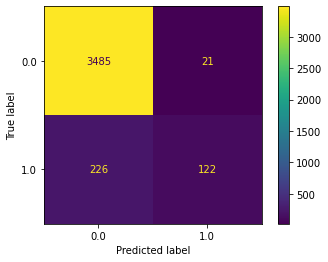

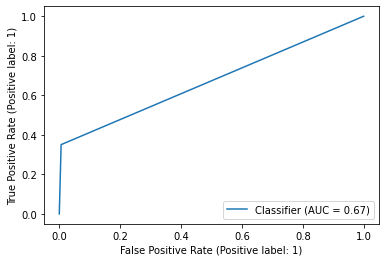

In [57]:
nb = Pipeline ([('bayes', NaiveBayes ())])
nb.fit (rtrainData, rtrainLabels)
showMetrics (nb, rtestData, rtestLabels)

Загрузка параметров в файл .pkl

In [58]:
with open ('naiveBayes.pkl', 'wb') as f:
    pickle.dump (nb, f, pickle.HIGHEST_PROTOCOL)

Коробочное решение

Accuracy:  0.949538162858887
Precision:  0.7407650847903247
Recall:  0.6472919418758256


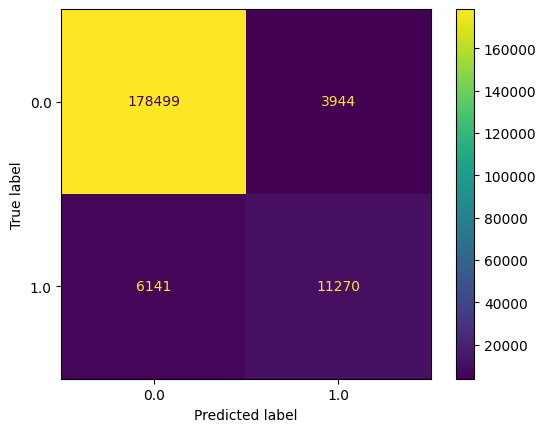

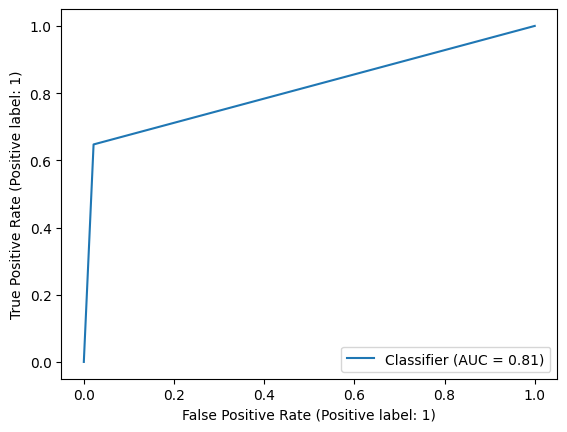

In [10]:
from sklearn.naive_bayes import GaussianNB
gnbSK = GaussianNB ()
gnbSK.fit (trainData, trainLabels)
showMetrics (gnbSK, testData, testLabels)